In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

# Step 1: Load the dataset
df = pd.read_csv('zomato.csv')

# Step 2: Handle missing and irrelevant values
# Drop irrelevant columns
df = df.drop(columns=['address', 'name', 'phone', 'location', 'dish_liked', 'listed_in(type)'])

# Drop rows with missing values in the target variable
df = df.dropna(subset=['approx_cost(for two people)'])

# Check if 'rates' column is present in the DataFrame
if 'rate' in df.columns:
    # Extract numeric ratings from 'rate' column and convert to float
    df['rate'] = df['rate'].str.extract('(\d+\.\d+)').astype(float)

# Convert 'online_order' and 'book_table' columns to binary (0 or 1)
df['online_order'] = df['online_order'].map({'Yes': 1, 'No': 0})
df['book_table'] = df['book_table'].map({'Yes': 1, 'No': 0})

# Convert 'votes' column to numeric
df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

# Clean the 'approx_cost(for two people)' column by removing non-numeric characters
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',', '', regex=True)

# Convert 'approx_cost(for two people)' column to numeric (float)
df['approx_cost(for two people)'] = pd.to_numeric(df['approx_cost(for two people)'], errors='coerce')

# Impute missing values in 'approx_cost(for two people)' column with the mean value
mean_cost = df['approx_cost(for two people)'].mean()
df['approx_cost(for two people)'].fillna(mean_cost, inplace=True)

# Convert 'cuisines' column to a list of cuisines and handle missing values
df['cuisines'] = df['cuisines'].apply(lambda x: [] if pd.isna(x) else x.split(','))

# Convert 'rest_type' column to a list of rest_type and handle missing values
df['rest_type'] = df['rest_type'].apply(lambda x: [] if pd.isna(x) else x.split(','))

# Step 3: Prepare the data for training
# Limit the number of unique values in the 'rest_type' column to reduce overlap in column names
max_unique_rest_type = 10
rest_type_counts = df['rest_type'].explode().value_counts()
top_rest_types = rest_type_counts.nlargest(max_unique_rest_type).index
df['rest_type'] = df['rest_type'].apply(lambda x: [r for r in x if r in top_rest_types])

# Use MultiLabelBinarizer to one-hot encode 'cuisines' and 'rest_type' columns
mlb = MultiLabelBinarizer()

cuisines_encoded = pd.DataFrame(mlb.fit_transform(df['cuisines']),
                                columns=[f"Cuisine_{cuisine}" for cuisine in mlb.classes_],
                                index=df.index)

rest_type_encoded = pd.DataFrame(mlb.fit_transform(df['rest_type']),
                                 columns=[f"Rest_Type_{rest_type}" for rest_type in mlb.classes_],
                                 index=df.index)

df = pd.concat([df, cuisines_encoded, rest_type_encoded], axis=1)

# Drop the original 'cuisines' and 'rest_type' columns
df = df.drop(columns=['cuisines', 'rest_type'])
# Step 4: Split the data into training and testing sets
X = df.drop(columns=['approx_cost(for two people)'])
y = df['approx_cost(for two people)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Handle missing values
# Check if there are any missing values in X_train and X_test
print("Number of missing values in X_train:")
print(X_train.isnull().sum())
print("\nNumber of missing values in X_test:")
print(X_test.isnull().sum())

# Assuming you found missing values, you can impute them using the mean or median value of each feature
# Example: Impute missing values with the mean value of the respective feature
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Step 6: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Apply PCA to reduce the number of features
pca = PCA(n_components=100)  # You can adjust the number of components as needed
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

# Step 7: Train a machine learning model (Linear Regression in this case)
model = LinearRegression()
model.fit(X_train_scaled_pca, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Linear Regression:')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Step 8: Use SGDRegressor with incremental learning
model_sgd = SGDRegressor()

# Process the data in mini-batches
batch_size = 1000
num_batches = len(X_train_scaled) // batch_size

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    X_batch = X_train_scaled[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    model_sgd.partial_fit(X_batch, y_batch)

# Predict on the test set
y_pred_sgd = model_sgd.predict(X_test_scaled)

# Evaluate the model
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)
print(f'SGDRegressor (Incremental Learning):')
print(f'Mean Squared Error: {mse_sgd}')
print(f'R-squared: {r2_sgd}')


Number of missing values in X_train:
online_order                                                                                                                                                                                           3507
book_table                                                                                                                                                                                             3507
rate                                                                                                                                                                                                  10525
votes                                                                                                                                                                                                  3507
Cuisine_ ""RATED\n  1)Pancakes were soggy.\n2)Menu said it comes with maple syrup but I didn't I get any. 3)French toast is not the same as bread w

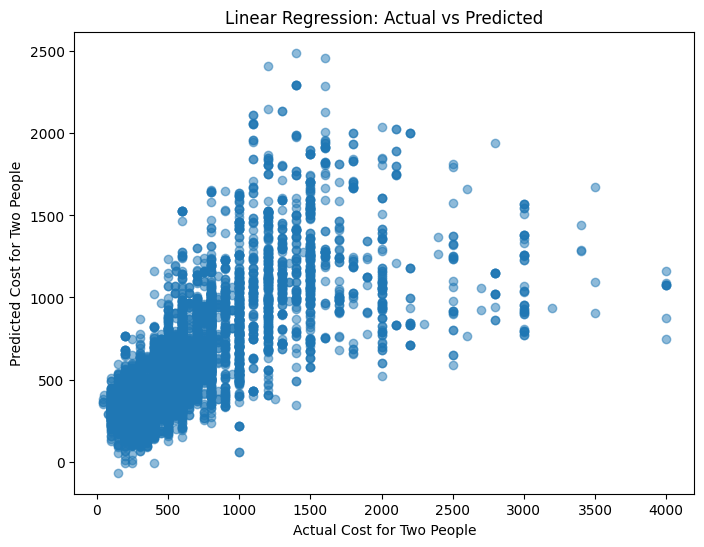

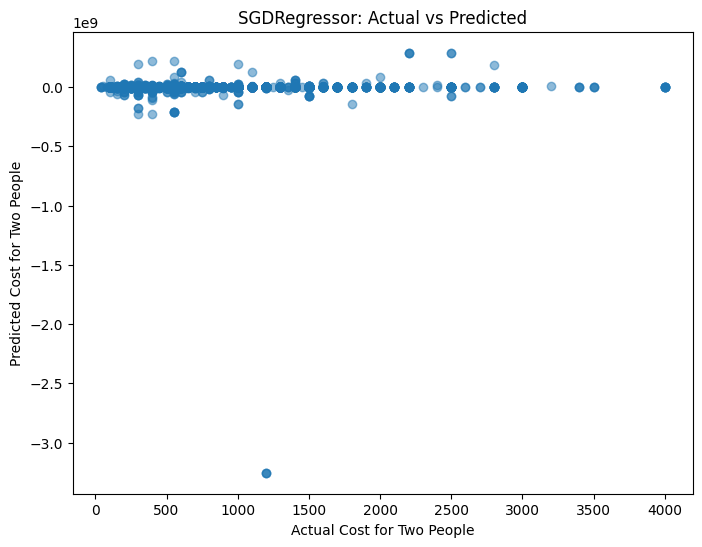

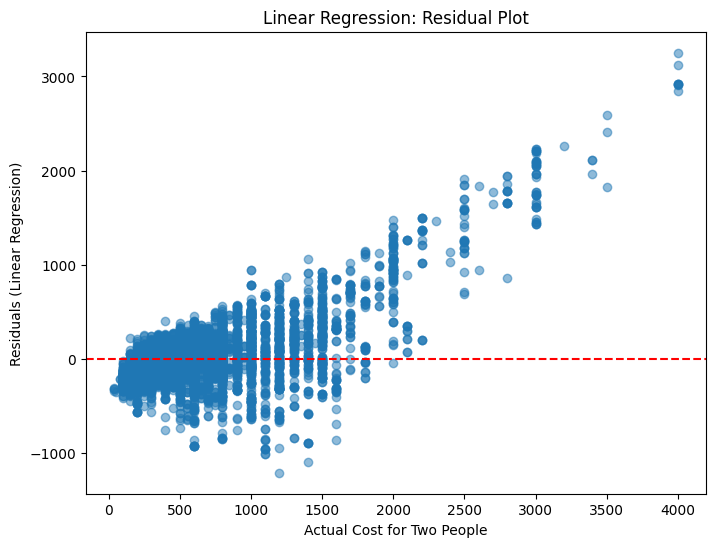

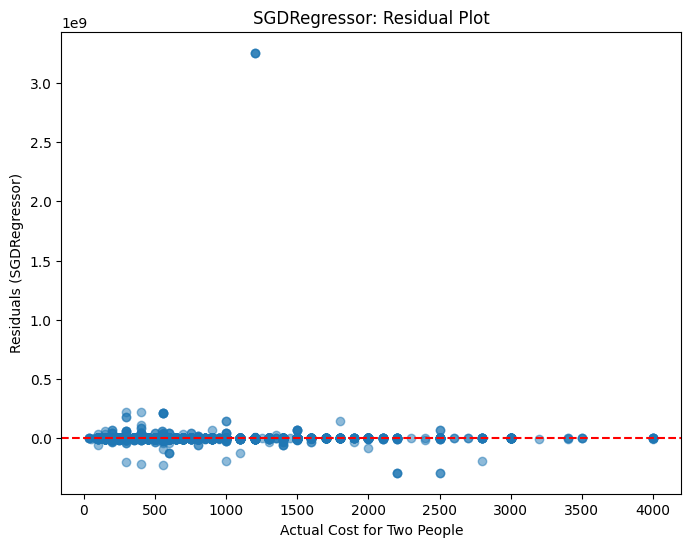

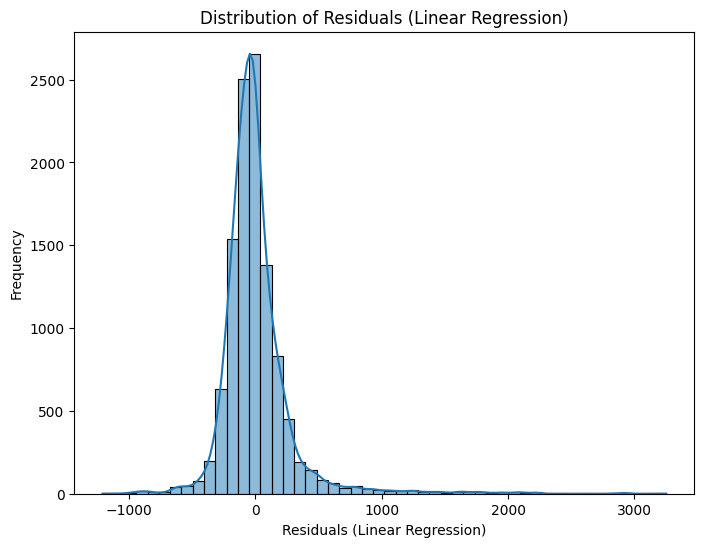

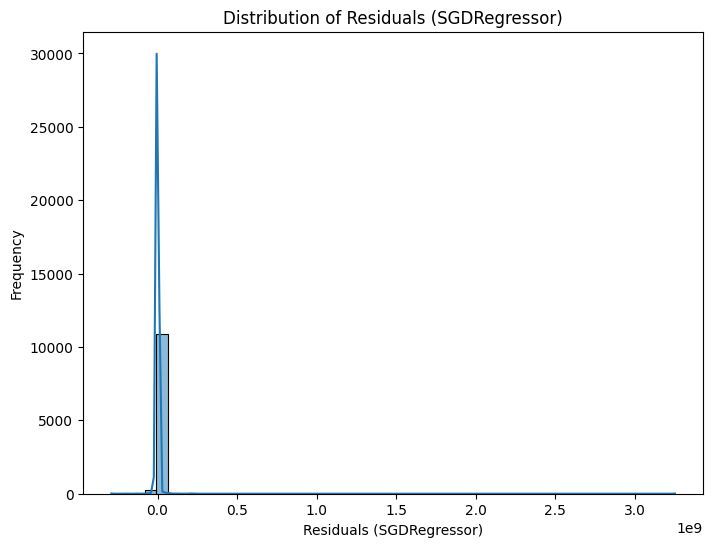

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Cost for Two People')
plt.ylabel('Predicted Cost for Two People')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

# Scatter plot for SGDRegressor
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_sgd, alpha=0.5)
plt.xlabel('Actual Cost for Two People')
plt.ylabel('Predicted Cost for Two People')
plt.title('SGDRegressor: Actual vs Predicted')
plt.show()

# Residual plots
residuals_linear = y_test - y_pred
residuals_sgd = y_test - y_pred_sgd

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_linear, alpha=0.5)
plt.xlabel('Actual Cost for Two People')
plt.ylabel('Residuals (Linear Regression)')
plt.title('Linear Regression: Residual Plot')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals_sgd, alpha=0.5)
plt.xlabel('Actual Cost for Two People')
plt.ylabel('Residuals (SGDRegressor)')
plt.title('SGDRegressor: Residual Plot')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.show()

# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_linear, bins=50, kde=True)
plt.xlabel('Residuals (Linear Regression)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Linear Regression)')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(residuals_sgd, bins=50, kde=True)
plt.xlabel('Residuals (SGDRegressor)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (SGDRegressor)')
plt.show()


In [8]:
from sklearn.tree import DecisionTreeRegressor

decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train_scaled_pca, y_train)

# Evaluate the model
y_pred_dt = decision_tree_model.predict(X_test_scaled_pca)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f'Decision Tree Regression:')
print(f'Mean Squared Error: {mse_dt}')
print(f'R-squared: {r2_dt}')

Decision Tree Regression:
Mean Squared Error: 45212.238335259965
R-squared: 0.7531071578209371


In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train_scaled_pca, y_train)

# Evaluate the model
y_pred_rf = random_forest_model.predict(X_test_scaled_pca)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Regression:')
print(f'Mean Squared Error: {mse_rf}')
print(f'R-squared: {r2_rf}')

gradient_boosting_model = GradientBoostingRegressor()
gradient_boosting_model.fit(X_train_scaled_pca, y_train)

# Evaluate the model
y_pred_gb = gradient_boosting_model.predict(X_test_scaled_pca)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting Regression:')
print(f'Mean Squared Error: {mse_gb}')
print(f'R-squared: {r2_gb}')



Random Forest Regression:
Mean Squared Error: 13846.165791426816
R-squared: 0.9243895159496702
Gradient Boosting Regression:
Mean Squared Error: 50518.402297717614
R-squared: 0.724131509854895


In [ ]:
from sklearn.svm import SVR
svr_model = SVR()
svr_model.fit(X_train_scaled_pca, y_train)

# Evaluate the model
y_pred_svr = svr_model.predict(X_test_scaled_pca)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f'Support Vector Regression (SVR):')
print(f'Mean Squared Error: {mse_svr}')
print(f'R-squared: {r2_svr}')


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
# Step 11: Train a K-Nearest Neighbors (KNN) Regression model
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled_pca, y_train)

# Evaluate the model
y_pred_knn = knn_model.predict(X_test_scaled_pca)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors (KNN) Regression:')
print(f'Mean Squared Error: {mse_knn}')
print(f'R-squared: {r2_knn}')